In [18]:
import os
from pprint import pprint as pp
import pandas as pd
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import copy
import seaborn as sns

%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [19]:
df_timeseries = pd.read_pickle('df_steamdb_timeseries.pkl')
df_prob = pd.read_pickle('df_sale_prob.pkl')

0.000000    3552
1.000000     279
0.100000     105
0.200000      62
0.900000      30
0.800000      29
0.300000      29
0.500000      21
0.600000      18
0.700000      17
0.400000      16
0.333333       3
0.150000       1
0.783333       1
dtype: int64

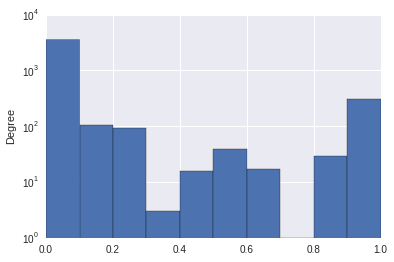

In [20]:
df_prob.sale_prob.plot(kind = 'hist')
plt.yscale('log')
pd.value_counts(df_prob.sale_prob)

In [21]:
sample = df_timeseries.formatted.iloc[2]
print sample

{u'1434049315000': {u'discount': 75, u'initial': u'$9.99', u'final': u'$2.49'}, u'1417120656000': {u'discount': 0, u'initial': u'$9.99', u'final': u'$9.99'}, u'1434996542000': {u'discount': 0, u'initial': u'$9.99', u'final': u'$9.99'}}


In [22]:
from re import sub
import decimal

def money_con(money):
    value = decimal.Decimal(sub(r'[^\d.]', '', money))
    value = float(value)
    return value


sample = df_timeseries.formatted.iloc[2]

master_discount_li = list()
master_savings_li = list()
for item in df_timeseries.iterrows():
    sample = item[1].formatted
    discount_li = list()
    savings_li = list()
    discount_avg = 0
    savings_avg = 0
    if type(sample) is dict:
        for k,v in sample.iteritems():
            cur_discount = v[u'discount']
            if cur_discount > 0:
                discount_li.append(cur_discount)
                savings = money_con(v[u'initial']) - money_con(v[u'final'])
                savings_li.append(savings)
        discount_avg =  np.mean(np.array([discount_li]))
        savings_avg =  np.mean(np.array([savings_li]))
    master_discount_li.append(discount_avg)
    master_savings_li.append(savings_avg)


In [23]:
df_save_discount = pd.DataFrame()
df_save_discount['appid'] =  df_timeseries.appid
df_save_discount['avg_savings'] = master_savings_li
df_save_discount['avg_discount'] = master_discount_li

In [24]:
df_save_discount = pd.merge(left=df_save_discount,right=df_prob, left_on='appid', right_on='appid')

In [25]:
df_save_discount.head()

,appid,avg_savings,avg_discount,sale_prob
0,297750,0.000000,37.500000,0
1,19080,7.500000,75.000000,0
2,278850,2.833333,56.666667,0
3,367260,1.257500,19.500000,1
4,251970,4.000000,80.000000,0


(array([    0.,   200.,   400.,   600.,   800.,  1000.]),
 <a list of 6 Text yticklabel objects>)

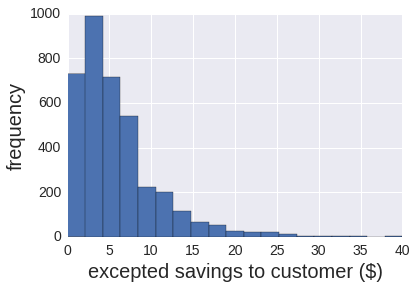

In [34]:
df_save_discount.avg_savings.plot(kind='hist',bins = np.linspace(0,40,20))
plt.xlabel('excepted savings to customer ($)', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

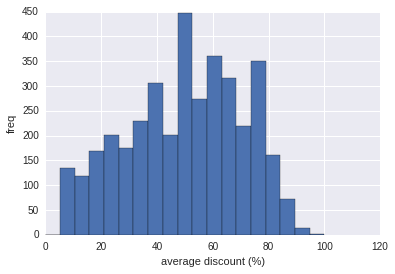

In [27]:
df_save_discount.avg_discount.plot(kind='hist',bins = np.linspace(0,100,20))
plt.xlabel('average discount (%)')
plt.ylabel('freq')

In [28]:
disc_amount = 20


def wait_score(sale_prob, disc_amount, loc_base = 0.5, disc_mod = 0.01):
    '''
    sale_prob: probabily of sale from the model
    disc_amount: expected amount of the discount
    '''
    #loc_base = 0.5
    #disc_mod = 0.01 #multiple by 0.01
    loc_mod = disc_amount * disc_mod 
    loc = loc_base - loc_mod
    y_l = stats.logistic.cdf(sale_prob, loc=loc, scale=.1)
    return y_l

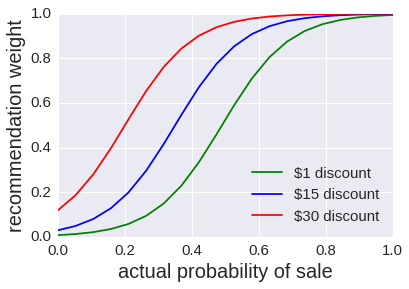

In [32]:
'''create graph demonstrating sigmoidal weight recommendation curve'''

# disc_amount = 5
# disc_mod = 0.01
# loc_base =0.5
# loc_mod = disc_amount * disc_mod
# loc = loc_base - loc_mod
# y_l = stats.logistic.cdf(x, loc=loc, scale=.1)

# disc_amount = 20
# loc_mod = disc_amount * disc_mod 
# loc = loc_base - loc_mod
# y_l_wait = stats.logistic.cdf(x, loc=loc, scale=.1)
# disc_amount = 30


def y_l(disc_amount,x):
    loc_base =0.5
    disc_mod = 0.01
    loc_mod = disc_amount * disc_mod 
    loc = loc_base - loc_mod
    y_l = stats.logistic.cdf(x, loc=loc, scale=.1)
    return y_l
x = np.linspace(0,1,20)
plt.plot(x,y_l(1,x),'g-', label = '$1 discount')
plt.plot(x,y_l(15,x),'b-', label = '$15 discount')
plt.plot(x,y_l(30,x),'r-', label = '$30 discount')
plt.xlabel('actual probability of sale', fontsize = 20)
plt.ylabel('recommendation weight', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'lower right', fontsize = 15)

In [ ]:
import matplotlib.colors as mcolors

def prob_rgba(weighted_prob):
    
    '''
    weighted_prob comes from the wait_score function
    make sure it's putting out the right colors for red/green whatever.
    Otherwise, transform the probabiliy (1-p) when it comes in.
    '''
    cdict = {'red':   ((0.0, 0.0, 0.0),
                       (0.5, 0.0, 0.0),
                       (1.0, 1.0, 1.0)),
             'blue':  ((0.0, 0.0, 0.0),
                       (1.0, 0.0, 0.0)),
             'green': ((0.0, 0.0, 1.0),
                       (0.5, 0.0, 0.0),
                       (1.0, 0.0, 0.0))}

    cmap = mcolors.LinearSegmentedColormap(
    'my_colormap', cdict, 100)

    
    rgba = cmap(int(weighted_prob * 100))
    rgba255 = [x*255 for x in rgba]
    rgba255[3] = rgba255[3] / 255
    #because the last item shouldn't actually have been multiplied, 
    #and this is quicker to code then a conditional list comprehension
    return rgba255

In [ ]:
df_save_discount.to_pickle('df_save_discount.pkl')